# BT5430 Assignment 2 
#### Hrutik Ravindra Pawar, Dhara Patel, Atharva Mandar Phatak

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from scipy.constants import R

In [79]:

class HelixCoilModelSSA:
    def __init__(self, n, sigma, s, temperature=298):
        #Single Sequence Approximation.
        self.n = n
        self.sigma = sigma 
        self.s = s         
        self.temperature = temperature
        self.R = R / 1000
        self.all_states = self.generate_ssa_states()
        
        
        self.graph = self.build_trans_graph()
        
    def generate_ssa_states(self):
        
        states = ['0' * self.n]  
        for start in range(self.n):
            for length in range(1, self.n - start + 1):
                state = '0' * start + '1' * length + '0' * (self.n - start - length)
                states.append(state)
                
        return states
    
    def is_valid_trans(self, state1, state2):

        diff_pos = []
        for i, (a, b) in enumerate(zip(state1, state2)):
            if a != b:
                diff_pos.append(i)
                if a == '1' and b == '0':  
                    return False
        
        
        if len(diff_pos) != 1:
            return False
            
        ones_blocks = state2.split('0')
        helical_blocks = [block for block in ones_blocks if block]
        return len(helical_blocks) <= 1
    
    def build_trans_graph(self):
        #Directed graph
        G = nx.DiGraph()
        
        for state in self.all_states:
            G.add_node(state)
 
        for state1 in self.all_states:
            for state2 in self.all_states:
                if self.is_valid_trans(state1, state2):
                    G.add_edge(state1, state2)
        
        return G
    
    def count_paths_dynamic(self, start, end):
        
        if start not in self.graph or end not in self.graph:
            raise ValueError(f"State {start} or {end} not found in graph.")

        path_counts = {state: 0 for state in self.all_states}
        path_counts[start] = 1
        states_by_level = defaultdict(list)
        for state in self.all_states:
            level = state.count('1')
            states_by_level[level].append(state)
        
        
        for level in range(self.n):
            for current in states_by_level[level]:
                for neighbor in self.graph.successors(current):
                    path_counts[neighbor] += path_counts[current]
        
        return path_counts[end]
    
    def trans_network_graph(self):
        if self.n <= 5:
            self.detailed_graph()
        else:
            self.abstract_graph()
    
    def detailed_graph(self):
        plt.figure(figsize=(12, 10))
        
        nodes_by_level = defaultdict(list)
        for state in self.all_states:
            level = state.count('1')
            nodes_by_level[level].append(state)
            


        pos = {}
        for level, nodes in nodes_by_level.items():
            nodes.sort()
            for i, node in enumerate(nodes):
                x_pos = i - (len(nodes) - 1) / 2
                pos[node] = (x_pos, level)
                

        nx.draw_networkx_nodes(self.graph, pos, node_size=300, 
                              node_color='lightblue', alpha=0.8)
        nx.draw_networkx_edges(self.graph, pos, arrows=True)
        nx.draw_networkx_labels(self.graph, pos, font_size=8)
        
        plt.title(f"Helix-Coil trans Microstates (n={self.n})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def abstract_graph(self):
        plt.figure(figsize=(12, 10))

        level_counts = defaultdict(int)
        for state in self.all_states:
            level = state.count('1')
            level_counts[level] += 1

        max_count = max(level_counts.values())
 
        for level in range(self.n + 1):
            count = level_counts[level]
            width = count / max_count * 12 
            
            rect = plt.Rectangle(
                (-width/2, level - 0.3), 
                width, 0.6, 
                facecolor='darkgray', 
                edgecolor='lightblue',
                linewidth=2,
                alpha=0.9
            )
            plt.gca().add_patch(rect)
            
            if count > 1:
                plt.text(0, level, f"{count}", 
                        ha='center', va='center', 
                        color='white', fontweight='bold')
        

        plt.text(0, -0.8, '0'*self.n, ha='center', va='center', 
                color='black', fontsize=10, fontweight='bold')
        plt.text(0, self.n + 0.8, '1'*self.n, ha='center', va='center', 
                color='black', fontsize=10, fontweight='bold')
        


        for level in range(self.n):
            plt.arrow(0, level + 0.4, 0, 0.3, head_width=0.3, 
                     head_length=0.2, fc='black', ec='black', width=0.05)
        
        plt.title(f"Helix-Coil trans Microstates with SSA (n={self.n})")
        plt.xlim(-7, 7)
        plt.ylim(-1.5, self.n + 1.5)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def run_monte_carlo(self, steps=10000):
        """Run Monte Carlo simulation using Metropolis criterion with SSA constraint."""
        kT = self.R * self.temperature  
        
        current_state = '0' * self.n #Unfolded state
        current_energy = self.state_energy(current_state)
        

        trajectory = [current_state]
        energies = [current_energy]
        helicity = [0.0]
        
        for step in range(steps):
       
            zeros_pos = [i for i, bit in enumerate(current_state) if bit == '0']
            
            if not zeros_pos:  
                break        
            pos = np.random.choice(zeros_pos)
            
            trial_state_list = list(current_state)
            trial_state_list[pos] = '1'
            trial_state = ''.join(trial_state_list)
            
            ones_blocks = trial_state.split('0')
            helical_blocks = [block for block in ones_blocks if block]
            
            if len(helical_blocks) <= 1: 
                trial_energy = self.state_energy(trial_state)
                
                delta_energy = trial_energy - current_energy
                
                #Metropolis criterion
                if delta_energy <= 0 or np.random.random() < np.exp(-delta_energy / kT):
                    current_state = trial_state
                    current_energy = trial_energy
        
            trajectory.append(current_state)
            energies.append(current_energy)
            helicity.append(current_state.count('1') / self.n)
        
        return trajectory, energies, helicity
    
    def state_energy(self, state):
        # Count helical residues
        n_helical = state.count('1')
        
        if n_helical == 0:
            return 0.0
        

        segments = 0
        in_segment = False
        
        for bit in state:
            if bit == '1' and not in_segment:
                segments += 1
                in_segment = True
            elif bit == '0':
                in_segment = False
        
        nucleation_energy = -np.log(self.sigma) * self.R * self.temperature
        propagation_energy = -np.log(self.s) * self.R * self.temperature
        
        total_energy = segments * nucleation_energy + (n_helical - segments) * propagation_energy
        
        return total_energy



Total SSA states for n=15: 121
Number of routes from 000000000000000 to 111111111111111: 16384


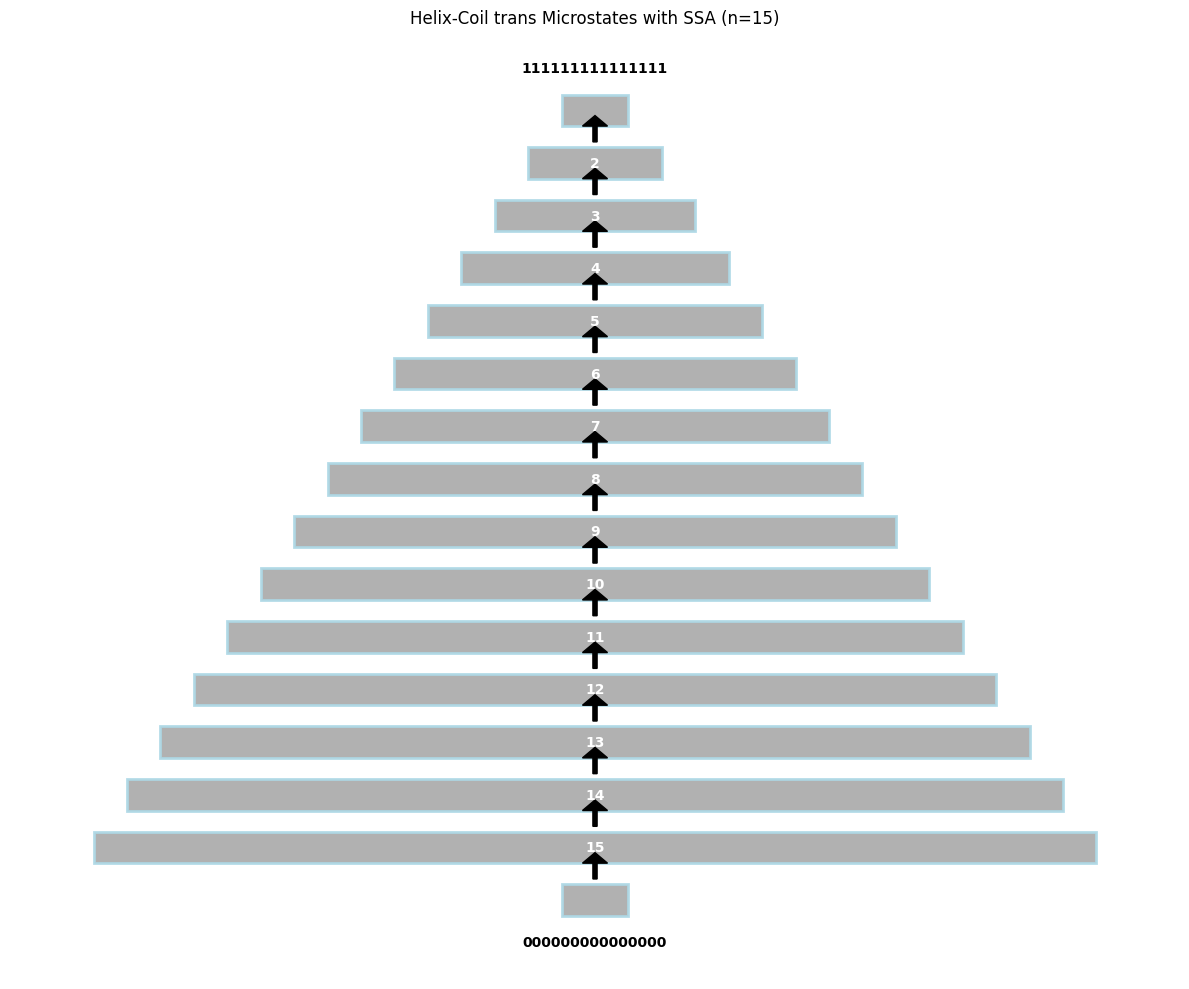

Monte Carlo simulation completed with 4198 steps
Final state: 111111111111111
Final helicity: 1.00


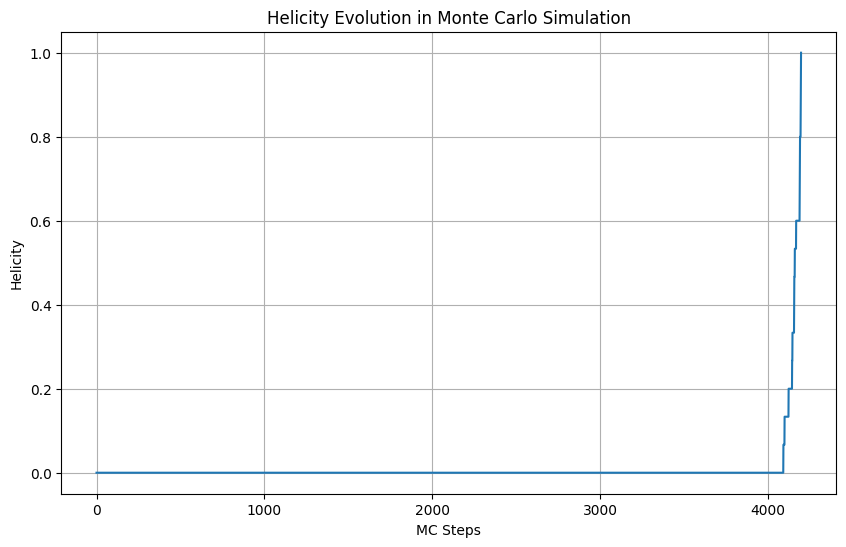

In [80]:
if __name__ == "__main__":
    n = 15
    sigma = 1e-3 
    s = 2.0  
    model = HelixCoilModelSSA(n, sigma, s)
    
    total_states = len(model.all_states)
    print(f"Total SSA states for n={n}: {total_states}")
    
    start_state = '0' * n  
    end_state = '1' * n   
    

    total_paths = model.count_paths_dynamic(start_state, end_state)
    print(f"Number of routes from {start_state} to {end_state}: {total_paths}")
    
    model.trans_network_graph()
    
    
    trajectory, energies, helicity = model.run_monte_carlo(steps=10000)
    print(f"Monte Carlo simulation completed with {len(trajectory)} steps")
    print(f"Final state: {trajectory[-1]}")
    print(f"Final helicity: {trajectory[-1].count('1')/n:.2f}")
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(helicity)
    plt.xlabel('MC Steps')
    plt.ylabel('Helicity')
    plt.title('Helicity Evolution in Monte Carlo Simulation')
    plt.grid(True)
    plt.show()
